# GECCO Constraints on RH Neutrino

In [8]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from matplotlib.ticker import LogLocator, NullFormatter

from hazma.parameters import (
    sv_inv_MeV_to_cm3_per_s,
    muon_mass as m_mu,
    charged_pion_mass as m_pi,
    neutral_pion_mass as m_pi0,
    electron_mass as m_e
)
from hazma import gamma_ray_parameters
from hazma.gamma_ray_parameters import *

from hazma.theory import TheoryDec
from hazma.rh_neutrino import RHNeutrino

import pickle

In [9]:
mxs = np.logspace(-1, np.log10(500.0), 100)
model = RHNeutrino(mxs[0], 1e-3, "e", True)

## Tools

In [3]:
# Other constants
T_obs_nt = 1e6  # s
v_mw = 1e-3
x_kd = 1e-6  # DM mass divided by T_kd

In [4]:
# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)
# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}

In [5]:
# Base figure size
fig_dim = 4
mpl_colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [6]:
def get_constraints(
    model,
    mxs,
    nt_targets={},
    existing=["comptel", "egret", "fermi", "integral"],
    cmb=True
):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i in trange(len(mxs)):
        model.mx = mxs[i]

        # Constraints from existing data
        for telescope in existing:
            constraints[telescope][i] = model.binned_limit(eval(f"{telescope}_diffuse"))

        # Projections
        for key, (target, bg_model) in nt_targets.items():
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco,
                energy_res_gecco,
                T_obs_nt,
                target,
                bg_model,
            )

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("comptel", "COMPTEL")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("integral", "INTEGRAL ")
    label = label.replace("gecco_", "GECCO ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def plot_existing(ax, mxs, svs, label, color, y2=1):
    """
    Plots an existing constraint.
    """
    if label == r"CMB ($s$-wave)":
        ax.plot(mxs[fs], svs, "-.k", linewidth=1, label=label)
    elif label == r"CMB ($p$-wave)":
        v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
        ax.plot(
            mxs, svs * (v_mw / v_cmbs)**2, "--k", linewidth=1, label=label
        )
    else:
        ax.fill_between(mxs, svs, y2=y2, label=label, alpha=0.2, color=color)
        ax.loglog(mxs, svs, "-", color=color, linewidth=0.5)

# Global formatting
colors = {
    "comptel": mpl_colors[0],
    "egret": mpl_colors[1],
    "fermi": mpl_colors[2],
    "integral": mpl_colors[3],
    "gc_ein_1_arcmin_cone_optimistic": mpl_colors[4],
    "gc_ein_5_deg_optimistic": mpl_colors[4],
    "gc_nfw_1_arcmin_cone": mpl_colors[5],
    "gc_nfw_5_deg": mpl_colors[5],
    "m31_nfw_1_arcmin_cone": mpl_colors[6],
    "m31_nfw_5_deg": mpl_colors[6],
    "draco_nfw_1_arcmin_cone": mpl_colors[7],
    "draco_nfw_5_deg": mpl_colors[7],
}

linestyles = {
    "gc_ein_1_arcmin_cone_optimistic": "-",
    "gc_ein_5_deg_optimistic": "-",
    "gc_nfw_1_arcmin_cone": "--",
    "gc_nfw_5_deg": "--",
    "m31_nfw_1_arcmin_cone": ":",
    "m31_nfw_5_deg": ":",
    "draco_nfw_1_arcmin_cone": ":",
    "draco_nfw_5_deg": ":",
}

## Compute Constraints

In [11]:
model = RHNeutrino(mxs[0], 1e-3, "e", True)
constraints_e = get_constraints(model, mxs, nt_targets=nt_targets_dec)

  0%|          | 0/100 [00:00<?, ?it/s]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(
 85%|████████▌ | 85/100 [1:03:15<22:57, 91.85s/it]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
 86%|████████▌ | 86/100 [1:04:50<21:38, 92.78s/it]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
 93%|█████████▎| 93/100 [1:16:12<11:21, 97.34s/it]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/rambo.py:236: Runtime

In [53]:
model = RHNeutrino(mxs[0], 1e-3, "mu", True)
constraints_mu = get_constraints(model, mxs, nt_targets=nt_targets_dec)

  0%|          | 0/100 [00:00<?, ?it/s]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(
 84%|████████▍ | 84/100 [00:48<00:09,  1.73it/s]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/theory/_theory_gamma_ray_limits.py:236: RuntimeWarning: divide by zero encountered in double_scalars
  bound = prefactor * n_sigma / np.nanmax(snrs[:, 2])
 89%|████████▉ | 89/100 [00:51<00:05,  1.94it/s]/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/rambo.py:236: RuntimeWarning: invalid value encountered in sqrt
  return histogram.space_to_energy_hist(
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: Integrati

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/haz

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/haz

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/haz

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/decay.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
 98%|█████████▊| 98/100 [17:14<04:20, 130.09s/it]/home/log

In [12]:
constraints_e['telescopes'] = np.array([
    np.min([
        constraints_e['comptel'][i],
        constraints_e['egret'][i],
        constraints_e['fermi'][i],
        constraints_e['integral'][i]
    ])
    for i in range(len(mxs))
])

In [54]:
constraints_mu['telescopes'] = np.array([
    np.min([
        constraints_mu['comptel'][i],
        constraints_mu['egret'][i],
        constraints_mu['fermi'][i],
        constraints_mu['integral'][i]
    ])
    for i in range(len(mxs))
])

## Save/Load Data

In [55]:
# Save the data
# with open('../data/rh_neutrino_e.p', 'wb') as f:
#    pickle.dump(constraints_e, f)
#with open('../data/rh_neutrino_mu.p', 'wb') as f:
#    pickle.dump(constraints_mu, f)

#Load the data
#constraints = None
#with open('../data/rh_neutrino.p', 'rb') as f:
#    constraints = pickle.load(f)


## Computing $\sin\theta$ from $\tau$ and $m_{\chi}$

In [70]:
def compute_stheta(mx, tau, lepton='e'):
    mod = RHNeutrino(mx, 1e-3, lepton=lepton, include_3body=True)
    
    def f(log_stheta):
        mod.stheta = 10.0**log_stheta
        # convert with to s^-1
        w = mod.decay_widths()['total'] * 1.52e21
        return 1.0 / w - tau
    
    root = root_scalar(f, bracket=(-30, 0))
    
    if root.converged:
        return 10**root.root
    else:
        return -1.0    

## Plots

In [22]:
colors = ['#1f77b4', 
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']

In [23]:
plt.rcParams['text.usetex'] = True

In [88]:
constraints = constraints_e
taus = np.geomspace(1e21, 1e29, 100)
sthetas = np.array([[compute_stheta(mx, tau, lepton='e') for tau in taus] for mx in mxs])

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/rh_neutrino/_rh_neutrino_widths.py:125: RuntimeWarning: divide by zero encountered in double_scalars
  return -(


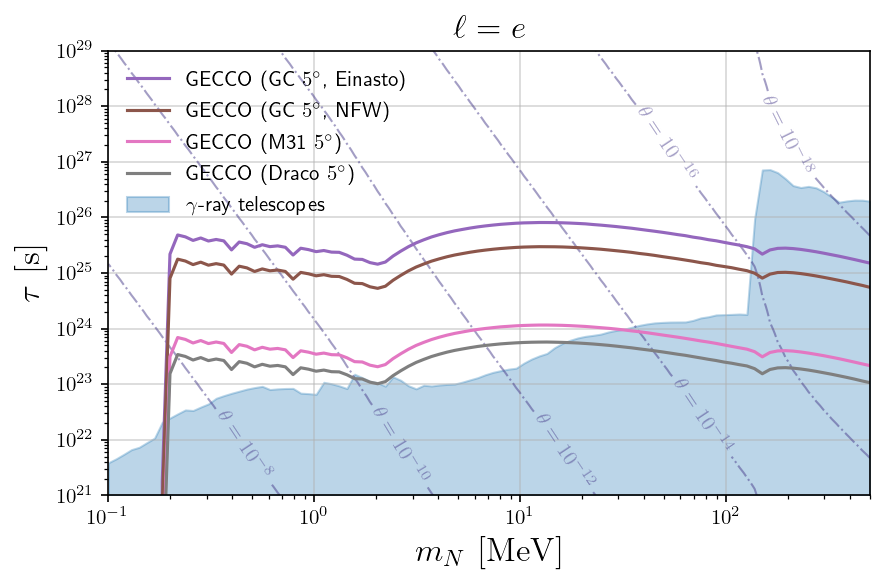

In [89]:
plt.figure(dpi=150)
ymin, ymax = [1e21, 1e29]

plt.yscale('log')
plt.xscale('log')

plt.fill_between(
    mxs, 
    y1=ymin,
    y2=1.0/constraints['telescopes'],  
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)



# for key in ['comptel', 'egret', 'fermi', 'integral']:
#    plt.plot(
#        mxs, 
#        1.0/constraints[key],  
#        #label=r'$\gamma$-ray telescopes',
#        linestyle="-",
#        color="grey",
#        alpha=0.5
#    )


plt.plot(
    mxs,     
    1.0/constraints['gecco_gc_ein_5_deg_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_5_deg_optimistic'),
    linestyle="-",
    color=colors[4],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_gc_nfw_5_deg'],  
    label=get_constraint_label('gecco_gc_nfw_5_deg'),
    linestyle="-",
    color=colors[5],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_m31_nfw_5_deg'],  
    label=get_constraint_label('gecco_m31_nfw_5_deg'),
    linestyle="-",
    color=colors[6],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_draco_nfw_5_deg'],  
    label=get_constraint_label('gecco_draco_nfw_5_deg'),
    linestyle="-",
    color=colors[7],
)


cs = plt.contour(
    mxs, 
    taus, 
    sthetas.T, 
    levels=[1e-18, 1e-16, 1e-14, 1e-12, 1e-10, 1e-8],
    alpha=0.5,
    colors="darkslateblue",
    linestyles="-.",
    linewidths=1
)

manual_locations = [(0.5, 1e22), (3, 1e22), (20, 1e22), (100, 5e22), (60, 3e27), (200, 3e27)]

plt.clabel(
    cs,
    fontsize=10,
    fmt={
        1e-18: r"$\theta=10^{-18}$",
        1e-16: r"$\theta=10^{-16}$",
        1e-14: r"$\theta=10^{-14}$",
        1e-12: r"$\theta=10^{-12}$",
        1e-10: r"$\theta=10^{-10}$",
        1e-8: r"$\theta=10^{-8}$",
    },
    use_clabeltext=True,
    colors="darkslateblue",
    rightside_up=True,
    inline=True,
    manual=manual_locations
)
    
    
plt.ylim([1e21, 1e29])
plt.xlim([np.min(mxs), np.max(mxs)])
plt.ylabel(r'$\tau \ [\mathrm{s}]$',fontsize=16)
plt.xlabel(r'$m_{N} \ [\mathrm{MeV}]$',fontsize=16)
plt.legend(frameon=False,loc=2)
plt.title(r"$\ell = e$", fontsize=16)
plt.tight_layout()
plt.grid(alpha=0.5)
plt.savefig('../figures/gecco_rh_neutrino_e.pdf')

In [90]:
constraints = constraints_mu
taus = np.geomspace(1e21, 1e29, 100)
sthetas = np.array([[compute_stheta(mx, tau, lepton='mu') for tau in taus] for mx in mxs])

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/rh_neutrino/_rh_neutrino_widths.py:125: RuntimeWarning: divide by zero encountered in double_scalars
  return -(


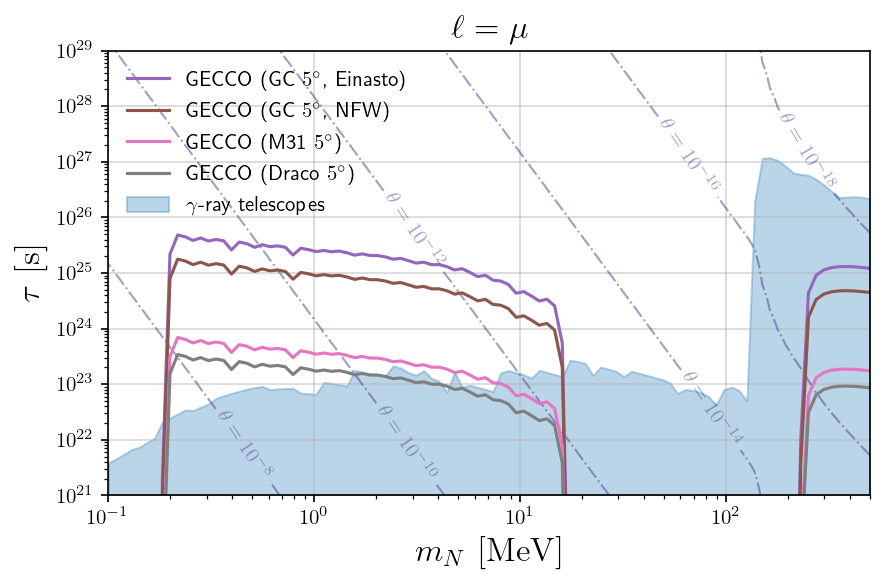

In [91]:
plt.figure(dpi=150)
ymin, ymax = [1e21, 1e29]

plt.yscale('log')
plt.xscale('log')

plt.fill_between(
    mxs, 
    y1=ymin,
    y2=1.0/constraints['telescopes'],  
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)



# for key in ['comptel', 'egret', 'fermi', 'integral']:
#    plt.plot(
#        mxs, 
#        1.0/constraints[key],  
#        #label=r'$\gamma$-ray telescopes',
#        linestyle="-",
#        color="grey",
#        alpha=0.5
#    )


plt.plot(
    mxs,     
    1.0/constraints['gecco_gc_ein_5_deg_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_5_deg_optimistic'),
    linestyle="-",
    color=colors[4],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_gc_nfw_5_deg'],  
    label=get_constraint_label('gecco_gc_nfw_5_deg'),
    linestyle="-",
    color=colors[5],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_m31_nfw_5_deg'],  
    label=get_constraint_label('gecco_m31_nfw_5_deg'),
    linestyle="-",
    color=colors[6],
)

plt.plot(
    mxs,     
    1.0/constraints['gecco_draco_nfw_5_deg'],  
    label=get_constraint_label('gecco_draco_nfw_5_deg'),
    linestyle="-",
    color=colors[7],
)


cs = plt.contour(
    mxs, 
    taus, 
    sthetas.T, 
    levels=[1e-18, 1e-16, 1e-14, 1e-12, 1e-10, 1e-8],
    alpha=0.5,
    colors="darkslateblue",
    linestyles="-.",
    linewidths=1
)

manual_locations = [(0.5, 1e22), (3, 1e22), (4, 1e26), (100, 5e22), (60, 1e27), (200, 1e27)]

plt.clabel(
    cs,
    fontsize=10,
    fmt={
        1e-18: r"$\theta=10^{-18}$",
        1e-16: r"$\theta=10^{-16}$",
        1e-14: r"$\theta=10^{-14}$",
        1e-12: r"$\theta=10^{-12}$",
        1e-10: r"$\theta=10^{-10}$",
        1e-8: r"$\theta=10^{-8}$",
    },
    use_clabeltext=True,
    colors="darkslateblue",
    rightside_up=True,
    inline=True,
    manual=manual_locations
)
    
    
plt.ylim([1e21, 1e29])
plt.xlim([np.min(mxs), np.max(mxs)])
plt.ylabel(r'$\tau \ [\mathrm{s}]$',fontsize=16)
plt.xlabel(r'$m_{N} \ [\mathrm{MeV}]$',fontsize=16)
plt.legend(frameon=False,loc=2)
plt.title(r"$\ell = \mu$", fontsize=16)
plt.tight_layout()
plt.grid(alpha=0.5)
plt.savefig('../figures/gecco_rh_neutrino_mu.pdf')

In [102]:
taus = np.geomspace(1e21, 1e29, 100)
sthetas_e = np.array([[compute_stheta(mx, tau, lepton='e') for tau in taus] for mx in mxs])
sthetas_mu = np.array([[compute_stheta(mx, tau, lepton='mu') for tau in taus] for mx in mxs])

/home/loganmorrison/.local/lib/python3.9/site-packages/hazma/rh_neutrino/_rh_neutrino_widths.py:125: RuntimeWarning: divide by zero encountered in double_scalars
  return -(


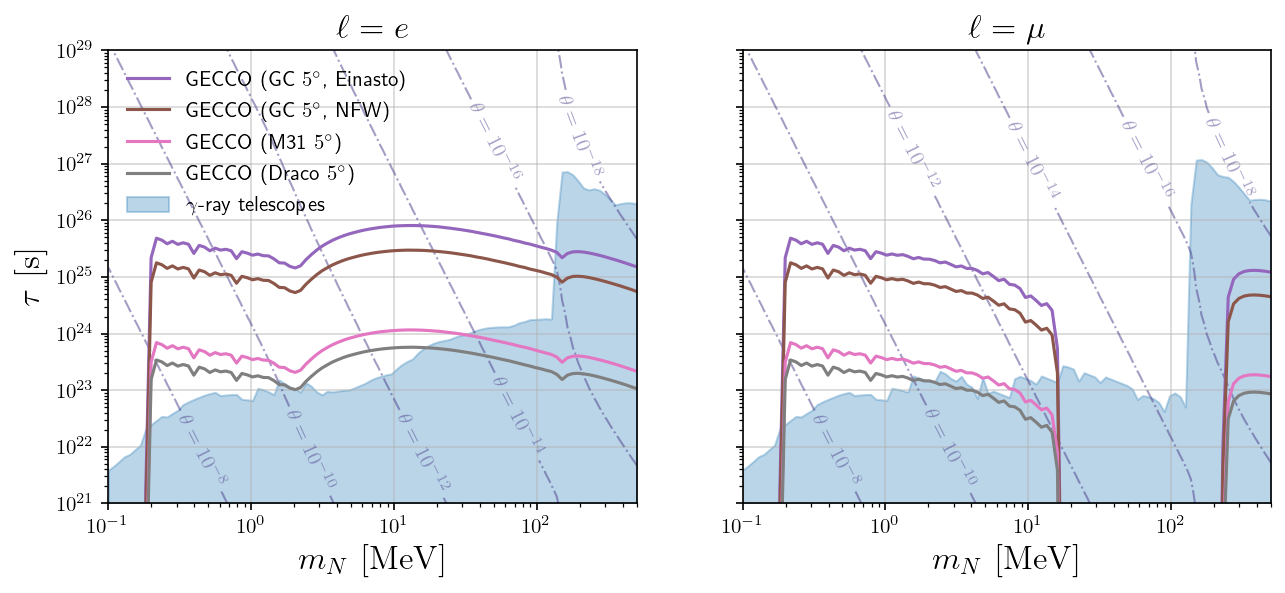

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
fig.dpi=150

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.fill_between(
    mxs, 
    y1=ymin,
    y2=1.0/constraints_e['telescopes'],  
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)


ax1.plot(
    mxs,     
    1.0/constraints_e['gecco_gc_ein_5_deg_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_5_deg_optimistic'),
    linestyle="-",
    color=colors[4],
)

ax1.plot(
    mxs,     
    1.0/constraints_e['gecco_gc_nfw_5_deg'],  
    label=get_constraint_label('gecco_gc_nfw_5_deg'),
    linestyle="-",
    color=colors[5],
)

ax1.plot(
    mxs,     
    1.0/constraints_e['gecco_m31_nfw_5_deg'],  
    label=get_constraint_label('gecco_m31_nfw_5_deg'),
    linestyle="-",
    color=colors[6],
)

ax1.plot(
    mxs,     
    1.0/constraints_e['gecco_draco_nfw_5_deg'],  
    label=get_constraint_label('gecco_draco_nfw_5_deg'),
    linestyle="-",
    color=colors[7],
)


cs = ax1.contour(
    mxs, 
    taus, 
    sthetas_e.T, 
    levels=[1e-18, 1e-16, 1e-14, 1e-12, 1e-10, 1e-8],
    alpha=0.5,
    colors="darkslateblue",
    linestyles="-.",
    linewidths=1
)

manual_locations = [(0.5, 1e22), (3, 1e22), (20, 1e22), (100, 5e22), (60, 3e27), (200, 3e27)]

ax1.clabel(
    cs,
    fontsize=10,
    fmt={
        1e-18: r"$\theta=10^{-18}$",
        1e-16: r"$\theta=10^{-16}$",
        1e-14: r"$\theta=10^{-14}$",
        1e-12: r"$\theta=10^{-12}$",
        1e-10: r"$\theta=10^{-10}$",
        1e-8: r"$\theta=10^{-8}$",
    },
    use_clabeltext=True,
    colors="darkslateblue",
    rightside_up=True,
    inline=True,
    manual=manual_locations
)
    
    
ax1.set_ylim([1e21, 1e29])
ax1.set_xlim([np.min(mxs), np.max(mxs)])
ax1.set_ylabel(r'$\tau \ [\mathrm{s}]$',fontsize=16)
ax1.set_xlabel(r'$m_{N} \ [\mathrm{MeV}]$',fontsize=16)
ax1.legend(frameon=False,loc=2)
ax1.set_title(r"$\ell = e$", fontsize=16)
ax1.grid(alpha=0.5)




ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.fill_between(
    mxs, 
    y1=ymin,
    y2=1.0/constraints_mu['telescopes'],  
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)


ax2.plot(
    mxs,     
    1.0/constraints_mu['gecco_gc_ein_5_deg_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_5_deg_optimistic'),
    linestyle="-",
    color=colors[4],
)

ax2.plot(
    mxs,     
    1.0/constraints_mu['gecco_gc_nfw_5_deg'],  
    label=get_constraint_label('gecco_gc_nfw_5_deg'),
    linestyle="-",
    color=colors[5],
)

ax2.plot(
    mxs,     
    1.0/constraints_mu['gecco_m31_nfw_5_deg'],  
    label=get_constraint_label('gecco_m31_nfw_5_deg'),
    linestyle="-",
    color=colors[6],
)

ax2.plot(
    mxs,     
    1.0/constraints_mu['gecco_draco_nfw_5_deg'],  
    label=get_constraint_label('gecco_draco_nfw_5_deg'),
    linestyle="-",
    color=colors[7],
)


cs = ax2.contour(
    mxs, 
    taus, 
    sthetas_mu.T, 
    levels=[1e-18, 1e-16, 1e-14, 1e-12, 1e-10, 1e-8],
    alpha=0.5,
    colors="darkslateblue",
    linestyles="-.",
    linewidths=1
)

manual_locations = [(0.5, 1e22), (3, 1e22), (1, 1e27), (10, 1e27), (60, 1e27), (200, 1e27)]

ax2.clabel(
    cs,
    fontsize=10,
    fmt={
        1e-18: r"$\theta=10^{-18}$",
        1e-16: r"$\theta=10^{-16}$",
        1e-14: r"$\theta=10^{-14}$",
        1e-12: r"$\theta=10^{-12}$",
        1e-10: r"$\theta=10^{-10}$",
        1e-8: r"$\theta=10^{-8}$",
    },
    use_clabeltext=True,
    colors="darkslateblue",
    rightside_up=True,
    inline=True,
    manual=manual_locations
)
    
    
ax2.set_xlim([np.min(mxs), np.max(mxs)])
ax2.set_xlabel(r'$m_{N} \ [\mathrm{MeV}]$',fontsize=16)
ax2.set_title(r"$\ell = \mu$", fontsize=16)
ax2.grid(alpha=0.5)
plt.savefig('../figures/gecco_rh_neutrino_e_mu.pdf')

In [68]:
keys = RHNeutrino(mxs[0], np.max(sthetas)).decay_branching_fractions().keys()

widths1 = {key: [RHNeutrino(mx, np.max(sthetas),lepton='mu').decay_branching_fractions()[key] for mx in mxs] for key in keys}
widths2 = {key: [RHNeutrino(mx, np.min(sthetas),lepton='mu').decay_branching_fractions()[key] for mx in mxs] for key in keys}

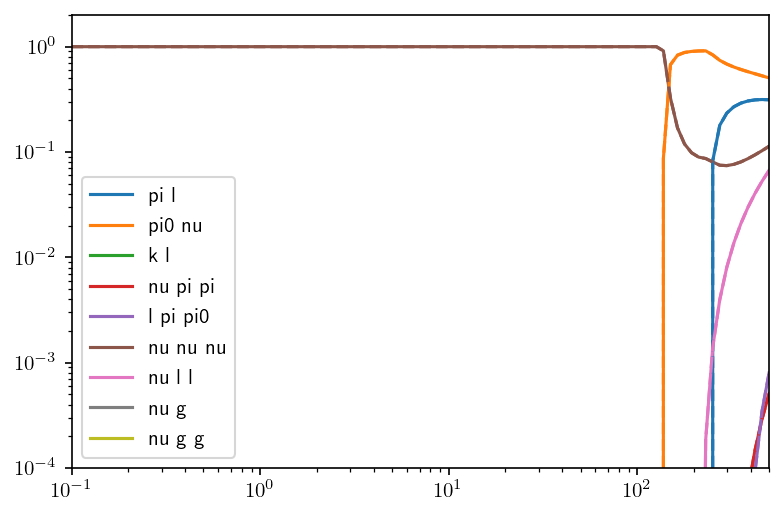

In [69]:
plt.figure(dpi=150)
for i, key in enumerate(keys):
    plt.loglog(mxs, widths1[key], label=key, ls='-', c=colors[i])
for i, key in enumerate(keys):
    plt.loglog(mxs, widths2[key], ls="--", c=colors[i])
plt.ylim([1e-4, 2])
plt.xlim([np.min(mxs), np.max(mxs)])
plt.legend()

In [51]:
from hazma.parameters import fpi, fpi0

In [52]:
(fpi, fpi0)

(92.2138, 91.924)